# ListenBrainz Collaborative Filtering - Data Exploration and Analysis
===================================================================

This notebook explores the ListenBrainz dataset and processes it step by step,
providing analysis and metrics at each stage to understand the data better.
It follows the same approach as the implementation files, using polars for data processing.


In [ ]:
import importlib
import json
from loguru import logger
import os
import subprocess
from difflib import SequenceMatcher
from typing import List, Optional, Set, Tuple

import matplotlib.pyplot as plt
import pandas as pd
import polars as pl
import seaborn as sns
import zstandard as zstd

In [41]:
# Set up logging for the notebook
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s'
)
logger = logging.getLogger("listenbrainz_exploration")

In [ ]:
# Set up paths
data_root = "/Volumes/WD Black/development/datasets/listenbrainz/data"  # Original data files
working_root = "../working"  # Processed files
scratch_root = "../data/scratch"  # Temporary files
parquet_dir = os.path.join(scratch_root, "parquet")

# Make sure directories exist
os.makedirs(working_root, exist_ok=True)
os.makedirs(scratch_root, exist_ok=True)
os.makedirs(parquet_dir, exist_ok=True)

In [43]:
# Set up plotting
plt.style.use('ggplot')
sns.set_theme(style="whitegrid")

In [5]:

# Helper functions for data analysis
def calculate_metrics(df, name="Dataset"):
    """Calculate and display basic metrics for a DataFrame."""
    if isinstance(df, pl.DataFrame):
        metrics = {
            "Number of rows": df.height,
            "Number of columns": df.width,
            "Memory usage": f"{df.estimated_size() / (1024 * 1024):.2f} MB"
        }
    else:
        metrics = {
            "Number of rows": len(df),
            "Number of columns": len(df.columns),
            "Memory usage": f"{df.memory_usage(deep=True).sum() / (1024 * 1024):.2f} MB"
        }
    
    print(f"=== {name} Metrics ===")
    for key, value in metrics.items():
        print(f"{key}: {value}")
    print()
    
    return metrics

def analyze_text_similarity(series, threshold=0.85, sample_size=1000):
    """Analyze a series for text items that are similar but not identical."""
    if len(series) <= 1:
        return pl.DataFrame()
    
    # Sample if the series is too large
    if len(series) > sample_size:
        sample = series.sample(sample_size, seed=42)
    else:
        sample = series
    
    # Convert to list for processing
    if isinstance(sample, pl.Series):
        sample_list = sample.to_list()
    else:
        sample_list = sample
    
    similar_pairs = []
    unique_values = list(set(sample_list))
    
    for i, val1 in enumerate(unique_values):
        for val2 in unique_values[i+1:]:
            similarity = SequenceMatcher(None, str(val1), str(val2)).ratio()
            if similarity >= threshold and similarity < 1.0:
                similar_pairs.append({
                    'value1': val1,
                    'value2': val2,
                    'similarity': similarity
                })
    
    if similar_pairs:
        return pl.DataFrame(similar_pairs).sort("similarity", descending=True)
    return pl.DataFrame()


def track_data_flow(original_count, processed_count, step_name):
    """Track data flow between processing steps."""
    if original_count == 0:
        retention_pct = 0
    else:
        retention_pct = (processed_count / original_count) * 100
    
    loss_count = original_count - processed_count
    loss_pct = 100 - retention_pct
    
    print(f"=== Data Flow: {step_name} ===")
    print(f"Original count: {original_count:,}")
    print(f"Processed count: {processed_count:,}")
    print(f"Retained: {retention_pct:.2f}% ({processed_count:,} items)")
    print(f"Lost: {loss_pct:.2f}% ({loss_count:,} items)")
    print()
    
    return {
        "step": step_name,
        "original_count": original_count,
        "processed_count": processed_count,
        "retention_pct": retention_pct,
        "loss_count": loss_count,
        "loss_pct": loss_pct
    }

In [6]:

def decompress_zst_file(input_file: str, output_file: str = None) -> str:
    """Decompress a zstandard file using either Python's zstandard library or system command.
    
    This function is adapted from the listenbrainz_processor.py implementation.
    
    Args:
        input_file: Path to the zst file to decompress
        output_file: Path for the decompressed output (if None, removes the .zst extension)
        
    Returns:
        Path to the decompressed file
    """
    if output_file is None:
        output_file = input_file.rstrip('.zst')
    
    logger.info(f"Decompressing {input_file} to {output_file}")
    
    # Try to use Python's zstandard library first
    try:
        zstandard_spec = importlib.util.find_spec("zstandard")
        if zstandard_spec is not None:
            logger.info("Using Python's zstandard library for decompression")
            
            with open(input_file, 'rb') as f_in, open(output_file, 'wb') as f_out:
                dctx = zstd.ZstdDecompressor()
                dctx.copy_stream(f_in, f_out)
            
            logger.info(f"Successfully decompressed to {output_file}")
            return output_file
    except ImportError:
        logger.info("Python zstandard library not available, will try system command")
    except Exception as e:
        logger.warning(f"Error using Python's zstandard library: {str(e)}, will try system command")
    
    # Fall back to system command
    try:
        # Check if zstd is available
        which_result = subprocess.run(['which', 'zstd'], 
                                    capture_output=True, 
                                    text=True)
        
        if which_result.returncode != 0:
            raise RuntimeError("zstd command not found. Please install zstandard.")
        
        # Use zstd -d
        result = subprocess.run(['zstd', '-d', input_file, '-o', output_file], 
                                capture_output=True, 
                                text=True)
        
        if result.returncode != 0:
            raise RuntimeError(f"Decompression failed: {result.stderr}")
        
        logger.info(f"Successfully decompressed to {output_file}")
        return output_file
        
    except Exception as e:
        logger.error(f"Failed to decompress file: {str(e)}")
        raise


# 1. Exploring ListenBrainz Listens Data

In [18]:
def process_listens_file(input_file: str, max_rows: Optional[int] = None) -> Tuple[pl.DataFrame, Set[str]]:
    """Process a ListenBrainz listens file to extract user_id and recording_msid.
    
    This function returns a dataframe for exploration instead of writing to a file.
    
    Args:
        input_file: Path to the listen file
        max_rows: Maximum number of rows to process. If None, process all rows.
        
    Returns:
        A tuple of (DataFrame of user_id and recording_msid pairs, Set of unique MSIDs)
    """
    logger.info(f"Processing {input_file}")
    if max_rows is not None:
        logger.info(f"Limiting to {max_rows} rows")
    else:
         logger.info("Processing all rows")
    
    # Process in batches to manage memory
    rows = []
    unique_msids = set()
    batch_size = 10000
    batch = []
    
    try:
        with open(input_file, 'r') as f:
            for line_num, line in enumerate(f):
                if max_rows is not None and line_num >= max_rows:
                    break
                    
                try:
                    if line_num % 100000 == 0 and line_num > 0:
                        logger.info(f"Processed {line_num} lines from {input_file}")
                    
                    data = json.loads(line)
                    user_id = data['user_id']
                    
                    # Get recording_msid - could be in different locations depending on source
                    recording_msid = None
                    
                    # Try to get from top level
                    if 'recording_msid' in data:
                        recording_msid = data['recording_msid']
                    
                    # Try to get from track_metadata
                    if recording_msid is None and 'track_metadata' in data:
                        track_metadata = data['track_metadata']
                        if isinstance(track_metadata, dict):
                            # Check directly in track_metadata
                            if 'recording_msid' in track_metadata:
                                recording_msid = track_metadata['recording_msid']
                            
                            # Check in additional_info
                            if recording_msid is None and 'additional_info' in track_metadata:
                                additional_info = track_metadata['additional_info']
                                if isinstance(additional_info, dict) and 'recording_msid' in additional_info:
                                    recording_msid = additional_info['recording_msid']
                    
                    batch.append({
                        'user_id': user_id,
                        'recording_msid': recording_msid
                    })
                    
                    if recording_msid:
                        unique_msids.add(recording_msid)
                    
                    if len(batch) >= batch_size:
                        rows.extend(batch)
                        batch = []
                except json.JSONDecodeError as e:
                    logger.warning(f"JSON parse error at line {line_num}: {str(e)}. Skipping line.")
                    continue
                except KeyError as e:
                    logger.warning(f"Missing key at line {line_num}: {str(e)}. Skipping line.")
                    continue
                except Exception as e:
                    logger.warning(f"Error processing line {line_num}: {str(e)}. Skipping line.")
                    continue
    except Exception as e:
        logger.error(f"Error reading file {input_file}: {str(e)}")
        raise
    
    # Add any remaining items
    if batch:
        rows.extend(batch)
    
    # Create Polars DataFrame
    logger.info(f"Creating DataFrame with {len(rows)} rows")
    df = pl.DataFrame(rows)
    
    # Return DataFrame and unique MSIDs
    logger.info(f"Found {len(unique_msids)} unique MSIDs")
    return df, unique_msids

2025-02-25 20:54:52,313 - INFO - Processing /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/1.listens
2025-02-25 20:54:52,313 - INFO - Processing all rows


Preparing to load all ListenBrainz listen events...

Processing file 1/12...


2025-02-25 20:54:52,657 - INFO - Processed 100000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/1.listens
2025-02-25 20:54:52,986 - INFO - Processed 200000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/1.listens
2025-02-25 20:54:53,347 - INFO - Processed 300000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/1.listens
2025-02-25 20:54:53,708 - INFO - Processed 400000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/1.listens
2025-02-25 20:54:54,053 - INFO - Processed 500000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/1.listens
2025-02-25 20:54:54,404 - INFO - Processed 600000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/1.listens
2025-02-25 20:54:54,764 - INFO - Processed 700000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/1.listens
2025-02-25 20:54:55,108 - INFO - Processed 80000


Processing file 2/12...


2025-02-25 20:55:30,516 - INFO - Successfully decompressed to /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/2.listens
2025-02-25 20:55:30,517 - INFO - Processing /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/2.listens
2025-02-25 20:55:30,517 - INFO - Processing all rows
2025-02-25 20:55:30,866 - INFO - Processed 100000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/2.listens
2025-02-25 20:55:31,210 - INFO - Processed 200000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/2.listens
2025-02-25 20:55:31,541 - INFO - Processed 300000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/2.listens
2025-02-25 20:55:31,891 - INFO - Processed 400000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/2.listens
2025-02-25 20:55:32,230 - INFO - Processed 500000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/2.listens
2025-02-25 


Processing file 3/12...


2025-02-25 20:56:07,616 - INFO - Successfully decompressed to /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/3.listens
2025-02-25 20:56:07,616 - INFO - Processing /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/3.listens
2025-02-25 20:56:07,617 - INFO - Processing all rows
2025-02-25 20:56:07,953 - INFO - Processed 100000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/3.listens
2025-02-25 20:56:08,284 - INFO - Processed 200000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/3.listens
2025-02-25 20:56:08,617 - INFO - Processed 300000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/3.listens
2025-02-25 20:56:08,988 - INFO - Processed 400000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/3.listens
2025-02-25 20:56:09,327 - INFO - Processed 500000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/3.listens
2025-02-25 


Processing file 4/12...


2025-02-25 20:56:46,043 - INFO - Successfully decompressed to /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/4.listens
2025-02-25 20:56:46,043 - INFO - Processing /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/4.listens
2025-02-25 20:56:46,044 - INFO - Processing all rows
2025-02-25 20:56:46,397 - INFO - Processed 100000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/4.listens
2025-02-25 20:56:46,758 - INFO - Processed 200000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/4.listens
2025-02-25 20:56:47,116 - INFO - Processed 300000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/4.listens
2025-02-25 20:56:47,481 - INFO - Processed 400000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/4.listens
2025-02-25 20:56:47,834 - INFO - Processed 500000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/4.listens
2025-02-25 


Processing file 5/12...


2025-02-25 20:57:23,976 - INFO - Successfully decompressed to /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/5.listens
2025-02-25 20:57:23,976 - INFO - Processing /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/5.listens
2025-02-25 20:57:23,977 - INFO - Processing all rows
2025-02-25 20:57:24,312 - INFO - Processed 100000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/5.listens
2025-02-25 20:57:24,655 - INFO - Processed 200000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/5.listens
2025-02-25 20:57:24,997 - INFO - Processed 300000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/5.listens
2025-02-25 20:57:25,344 - INFO - Processed 400000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/5.listens
2025-02-25 20:57:25,697 - INFO - Processed 500000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/5.listens
2025-02-25 


Processing file 6/12...


2025-02-25 20:58:00,501 - INFO - Successfully decompressed to /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/6.listens
2025-02-25 20:58:00,501 - INFO - Processing /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/6.listens
2025-02-25 20:58:00,501 - INFO - Processing all rows
2025-02-25 20:58:00,852 - INFO - Processed 100000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/6.listens
2025-02-25 20:58:01,197 - INFO - Processed 200000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/6.listens
2025-02-25 20:58:01,542 - INFO - Processed 300000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/6.listens
2025-02-25 20:58:01,904 - INFO - Processed 400000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/6.listens
2025-02-25 20:58:02,281 - INFO - Processed 500000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/6.listens
2025-02-25 


Processing file 7/12...


2025-02-25 20:58:34,002 - INFO - Successfully decompressed to /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/7.listens
2025-02-25 20:58:34,003 - INFO - Processing /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/7.listens
2025-02-25 20:58:34,003 - INFO - Processing all rows
2025-02-25 20:58:34,335 - INFO - Processed 100000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/7.listens
2025-02-25 20:58:34,663 - INFO - Processed 200000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/7.listens
2025-02-25 20:58:35,012 - INFO - Processed 300000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/7.listens
2025-02-25 20:58:35,373 - INFO - Processed 400000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/7.listens
2025-02-25 20:58:35,721 - INFO - Processed 500000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/7.listens
2025-02-25 


Processing file 8/12...


2025-02-25 20:59:07,784 - INFO - Successfully decompressed to /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/8.listens
2025-02-25 20:59:07,785 - INFO - Processing /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/8.listens
2025-02-25 20:59:07,785 - INFO - Processing all rows
2025-02-25 20:59:08,135 - INFO - Processed 100000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/8.listens
2025-02-25 20:59:08,488 - INFO - Processed 200000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/8.listens
2025-02-25 20:59:08,824 - INFO - Processed 300000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/8.listens
2025-02-25 20:59:09,175 - INFO - Processed 400000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/8.listens
2025-02-25 20:59:09,540 - INFO - Processed 500000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/8.listens
2025-02-25 


Processing file 9/12...


2025-02-25 20:59:40,300 - INFO - Successfully decompressed to /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/9.listens
2025-02-25 20:59:40,301 - INFO - Processing /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/9.listens
2025-02-25 20:59:40,301 - INFO - Processing all rows
2025-02-25 20:59:40,638 - INFO - Processed 100000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/9.listens
2025-02-25 20:59:41,011 - INFO - Processed 200000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/9.listens
2025-02-25 20:59:41,355 - INFO - Processed 300000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/9.listens
2025-02-25 20:59:41,698 - INFO - Processed 400000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/9.listens
2025-02-25 20:59:42,073 - INFO - Processed 500000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/9.listens
2025-02-25 


Processing file 10/12...


2025-02-25 21:00:12,425 - INFO - Successfully decompressed to /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/10.listens
2025-02-25 21:00:12,426 - INFO - Processing /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/10.listens
2025-02-25 21:00:12,426 - INFO - Processing all rows
2025-02-25 21:00:12,771 - INFO - Processed 100000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/10.listens
2025-02-25 21:00:13,105 - INFO - Processed 200000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/10.listens
2025-02-25 21:00:13,440 - INFO - Processed 300000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/10.listens
2025-02-25 21:00:13,795 - INFO - Processed 400000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/10.listens
2025-02-25 21:00:14,153 - INFO - Processed 500000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/10.listens
2025


Processing file 11/12...


2025-02-25 21:00:46,088 - INFO - Successfully decompressed to /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/11.listens
2025-02-25 21:00:46,089 - INFO - Processing /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/11.listens
2025-02-25 21:00:46,089 - INFO - Processing all rows
2025-02-25 21:00:46,444 - INFO - Processed 100000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/11.listens
2025-02-25 21:00:46,793 - INFO - Processed 200000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/11.listens
2025-02-25 21:00:47,155 - INFO - Processed 300000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/11.listens
2025-02-25 21:00:47,513 - INFO - Processed 400000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/11.listens
2025-02-25 21:00:47,889 - INFO - Processed 500000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/11.listens
2025


Processing file 12/12...


2025-02-25 21:01:19,918 - INFO - Successfully decompressed to /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/12.listens
2025-02-25 21:01:19,918 - INFO - Processing /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/12.listens
2025-02-25 21:01:19,918 - INFO - Processing all rows
2025-02-25 21:01:20,276 - INFO - Processed 100000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/12.listens
2025-02-25 21:01:20,624 - INFO - Processed 200000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/12.listens
2025-02-25 21:01:20,991 - INFO - Processed 300000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/12.listens
2025-02-25 21:01:21,363 - INFO - Processed 400000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/12.listens
2025-02-25 21:01:21,729 - INFO - Processed 500000 lines from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/12.listens
2025


Combined data analysis:
=== Combined ListenBrainz Listens (User-MSID Pairs) Metrics ===
Number of rows: 93859039
Number of columns: 2
Memory usage: 3938.48 MB


Null values in each column:
user_id: 0 (0.00%)
recording_msid: 0 (0.00%)

Number of duplicate rows: 70371764 (74.98%)

Number of unique users: 16073
Number of unique MSIDs: 16684273


/var/folders/n1/mcq0j79n6y55kkrdd26_v_qr0000gn/T/ipykernel_86895/1375219844.py:57: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  user_listen_counts = user_msid_df.group_by("user_id").count().sort("count", descending=True)
2025-02-25 21:02:01,219 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-02-25 21:02:01,220 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.



User listening statistics:
shape: (1, 4)
┌──────────────────────────┬─────────────────────────┬──────────────────────┬──────────────────────┐
│ Average listens per user ┆ Median listens per user ┆ Min listens per user ┆ Max listens per user │
│ ---                      ┆ ---                     ┆ ---                  ┆ ---                  │
│ f64                      ┆ f64                     ┆ u32                  ┆ u32                  │
╞══════════════════════════╪═════════════════════════╪══════════════════════╪══════════════════════╡
│ 5839.547004              ┆ 1700.0                  ┆ 1                    ┆ 678011               │
└──────────────────────────┴─────────────────────────┴──────────────────────┴──────────────────────┘


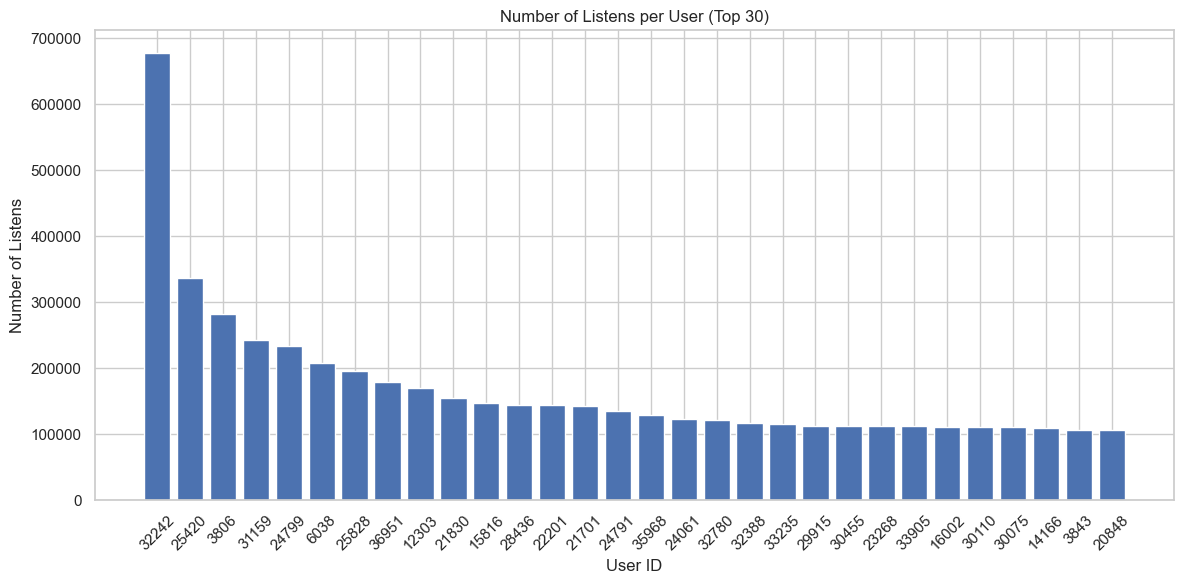

/var/folders/n1/mcq0j79n6y55kkrdd26_v_qr0000gn/T/ipykernel_86895/1375219844.py:88: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  ).group_by("recording_msid").count().sort("count", descending=True)



Recording popularity statistics:
shape: (1, 4)
┌─────────────────────┬────────────────────┬─────────────────┬───────────────────────────┐
│ Average listens per ┆ Median listens per ┆ Min listens per ┆ Max listens per recording │
│ recording           ┆ recording          ┆ recording       ┆ ---                       │
│ ---                 ┆ ---                ┆ ---             ┆ u32                       │
│ f64                 ┆ f64                ┆ u32             ┆                           │
╞═════════════════════╪════════════════════╪═════════════════╪═══════════════════════════╡
│ 5.6256              ┆ 1.0                ┆ 1               ┆ 45998                     │
└─────────────────────┴────────────────────┴─────────────────┴───────────────────────────┘


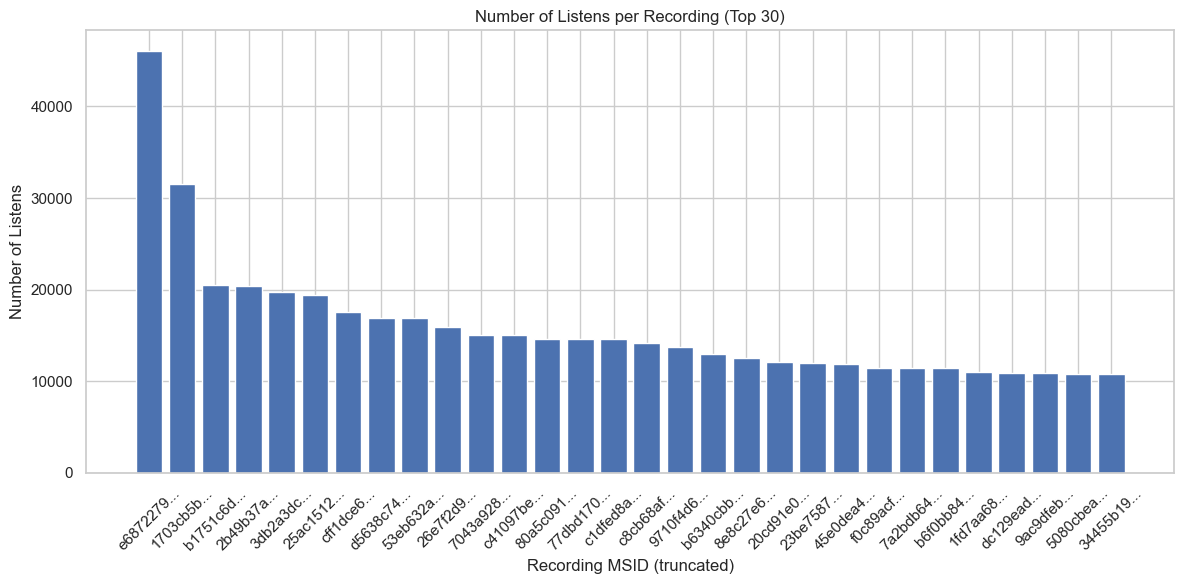

In [19]:
print("Preparing to load all ListenBrainz listen events...")

all_user_msid_dfs = []

# Process files 1 through 12
for file_num in range(1, 13):
    listen_file_path = os.path.join(data_root, f"{file_num}.listens.zst")
    decompressed_path = os.path.join(scratch_root, f"{file_num}.listens")
    
    print(f"\nProcessing file {file_num}/12...")
    
    if not os.path.exists(decompressed_path):
        if os.path.exists(listen_file_path):
            decompressed_path = decompress_zst_file(listen_file_path, decompressed_path)
        else:
            # Try with the provided sample file
            listen_file_path = f"{file_num}.listens_sample.json"
            if os.path.exists(listen_file_path):
                decompressed_path = listen_file_path
            else:
                print(f"Warning: Could not find {listen_file_path}, skipping...")
                continue

    # Process each listens file
    df, msids = process_listens_file(decompressed_path)
    all_user_msid_dfs.append(df)

# Combine all dataframes
user_msid_df = pl.concat(all_user_msid_dfs)

print("\nCombined data analysis:")
# Display basic statistics
calculate_metrics(user_msid_df, "Combined ListenBrainz Listens (User-MSID Pairs)")

# Count nulls
null_counts = user_msid_df.null_count()
print("\nNull values in each column:")
for col, count in zip(user_msid_df.columns, null_counts.row(0)):
    print(f"{col}: {count} ({count/user_msid_df.height*100:.2f}%)")

# Check for duplicates
duplicates = user_msid_df.select(
    pl.col("user_id"),
    pl.col("recording_msid")
).is_duplicated().sum()

print(f"\nNumber of duplicate rows: {duplicates} ({duplicates/user_msid_df.height*100:.2f}%)")

# Count unique values
unique_users = user_msid_df.select("user_id").n_unique()
unique_msids_count = user_msid_df.filter(pl.col("recording_msid").is_not_null()).select("recording_msid").n_unique()

print(f"\nNumber of unique users: {unique_users}")
print(f"Number of unique MSIDs: {unique_msids_count}")

# Analyze user listening patterns
user_listen_counts = user_msid_df.group_by("user_id").count().sort("count", descending=True)
user_listen_counts = user_listen_counts.with_columns(
    pl.col("count").alias("listen_count")
).drop("count")

print("\nUser listening statistics:")
listen_count_stats = user_listen_counts.select(
    pl.col("listen_count").mean().alias("Average listens per user"),
    pl.col("listen_count").median().alias("Median listens per user"),
    pl.col("listen_count").min().alias("Min listens per user"),
    pl.col("listen_count").max().alias("Max listens per user")
)
print(listen_count_stats)

# Plot distribution of listens per user (top 30)
top_users = user_listen_counts.head(30)
plt.figure(figsize=(12, 6))
plt.bar(
    [str(u) for u in top_users["user_id"].to_list()], 
    top_users["listen_count"].to_list()
)
plt.title('Number of Listens per User (Top 30)')
plt.xlabel('User ID')
plt.ylabel('Number of Listens')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Analyze recording popularity
recording_counts = user_msid_df.filter(
    pl.col("recording_msid").is_not_null()
).group_by("recording_msid").count().sort("count", descending=True)
recording_counts = recording_counts.with_columns(
    pl.col("count").alias("listen_count")
).drop("count")

print("\nRecording popularity statistics:")
recording_stats = recording_counts.select(
    pl.col("listen_count").mean().alias("Average listens per recording"),
    pl.col("listen_count").median().alias("Median listens per recording"),
    pl.col("listen_count").min().alias("Min listens per recording"),
    pl.col("listen_count").max().alias("Max listens per recording")
)
print(recording_stats)

# Plot distribution of listens per recording (top 30)
top_recordings = recording_counts.head(30)
plt.figure(figsize=(12, 6))
plt.bar(
    [str(r)[:8] + "..." for r in top_recordings["recording_msid"].to_list()], 
    top_recordings["listen_count"].to_list()
)
plt.title('Number of Listens per Recording (Top 30)')
plt.xlabel('Recording MSID (truncated)')
plt.ylabel('Number of Listens')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



# 2. Exploring MSID to MBID Mapping

In [ ]:
# Save the user_msid_df as parquet
output_path = os.path.join(parquet_dir, "userid-msid.parquet")
logger.info(f"Saving user-msid mapping to {output_path}")
user_msid_df.write_parquet(output_path)

print(f"Saved {user_msid_df.height:,} rows to {output_path}")

2025-02-25 21:12:44,672 - INFO - Saving user-msid mapping to /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/parquet/userid-msid.parquet


Saved 93,859,039 rows to /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/parquet/userid-msid.parquet


2025-02-25 21:45:52,656 - INFO - Calculated 16684273 unique MSIDs from user data
2025-02-25 21:45:52,659 - INFO - Loading MSID mapping from /Volumes/WD Black/development/datasets/listenbrainz/data/scratch/parquet/msid_mapping.parquet
2025-02-25 21:45:53,018 - INFO - Filtering mapping to 16684273 MSIDs
2025-02-25 21:46:12,346 - INFO - Filtering mapping to quality levels: ['exact_match', 'high_quality', 'medium_quality', 'low_quality']
/var/folders/n1/mcq0j79n6y55kkrdd26_v_qr0000gn/T/ipykernel_86895/1193165117.py:71: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  match_type_counts = mapping_df.group_by("match_type").count().sort("count", descending=True)


=== MSID to MBID Mapping Metrics ===
Number of rows: 9175609
Number of columns: 3
Memory usage: 726.46 MB


Analyzing match types...
shape: (2, 3)
┌──────────────┬─────────┬────────────┐
│ match_type   ┆ count   ┆ percentage │
│ ---          ┆ ---     ┆ ---        │
│ str          ┆ u32     ┆ f64        │
╞══════════════╪═════════╪════════════╡
│ exact_match  ┆ 9001042 ┆ 98.097489  │
│ high_quality ┆ 174567  ┆ 1.902511   │
└──────────────┴─────────┴────────────┘


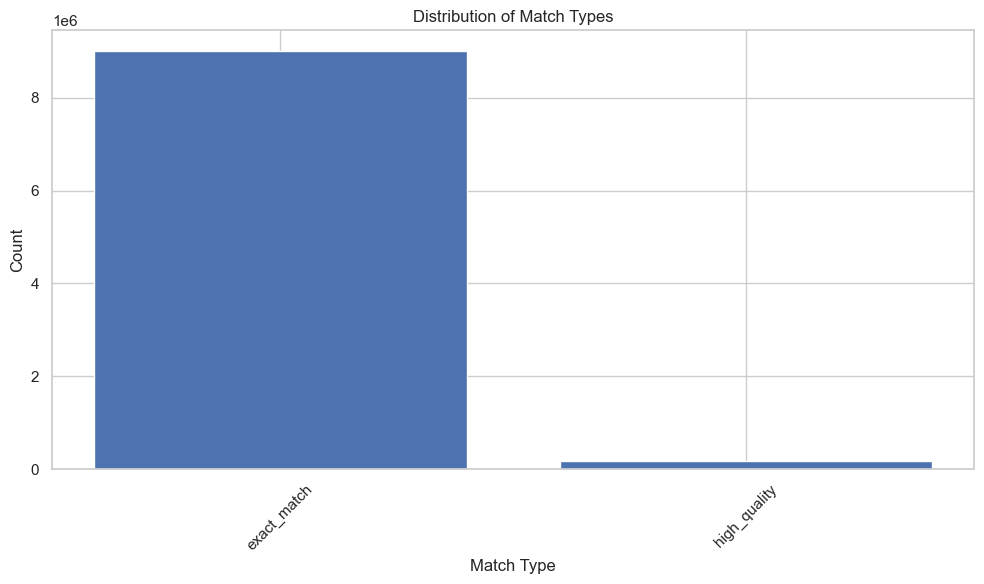


Checking for duplicates in the MSID to MBID mapping...
Number of duplicate MSIDs: 0 (0.00%)

Number of duplicate MBIDs: 6146197 (66.98%)

Checking mapping coverage for our listen data...
Total unique MSIDs in listen data: 16684273
MSIDs that can be mapped: 9175609 (55.00%)
MSIDs that cannot be mapped: 7508664 (45.00%)
=== Data Flow: MSID to MBID Mapping ===
Original count: 16,684,273
Processed count: 9,175,609
Retained: 55.00% (9,175,609 items)
Lost: 45.00% (7,508,664 items)



In [22]:
mapping_file_path = os.path.join(parquet_dir, "msid_mapping.parquet")

def load_msid_mapping(
    parquet_file_path: str,
    csv_file_path: str,
    unique_msids: Optional[Set[str]] = None,
    quality_levels: Optional[List[str]] = None,
    max_rows: Optional[int] = None
) -> pl.DataFrame:
    """Load and filter MSID to MBID mapping. First attempt to load from parquet.
    If not available, try reading from CSV (possibly decompressing), and read all rows unless max_rows is specified."""
    if quality_levels is None:
        quality_levels = ['exact_match', 'high_quality']
    
    row_limit = max_rows if max_rows is not None else None

    # Attempt to load from parquet first
    if os.path.exists(parquet_file_path):
        logger.info(f"Loading MSID mapping from {parquet_file_path}")
        df = pl.read_parquet(parquet_file_path, n_rows=row_limit)
    else:
        logger.info(f"Parquet file not found, checking for CSV: {csv_file_path}")
        if csv_file_path.endswith('.zst'):
            decompressed_path_local = os.path.join(scratch_root, os.path.basename(csv_file_path).replace('.zst', ''))
            if not os.path.exists(decompressed_path_local):
                decompressed_path_local = decompress_zst_file(csv_file_path, decompressed_path_local)
            csv_file_path = decompressed_path_local
        logger.info(f"Loading MSID mapping from {csv_file_path}")
        df = pl.read_csv(csv_file_path, n_rows=row_limit)

    # Filter by unique_msids if provided
    if unique_msids:
        logger.info(f"Filtering mapping to {len(unique_msids)} MSIDs")
        df = df.filter(pl.col("recording_msid").is_in(unique_msids))
    
    # Filter by quality levels if provided
    if quality_levels:
        logger.info(f"Filtering mapping to quality levels: {quality_levels}")
        df = df.filter(pl.col("match_type").is_in(quality_levels))
    
    return df

# Calculate unique_msids from user_msid_df
unique_msids = set(user_msid_df.get_column("recording_msid").unique().to_list())
logger.info(f"Calculated {len(unique_msids)} unique MSIDs from user data")

# Try loading from the Parquet file first; if not available, fall back to CSV
parquet_file = os.path.join(parquet_dir, "msid_mapping.parquet")
csv_zst_file = os.path.join(data_root, "listenbrainz_msid_mapping.csv.zst")

if os.path.exists(parquet_file) or os.path.exists(csv_zst_file):
    mapping_df = load_msid_mapping(parquet_file, csv_zst_file, unique_msids, quality_levels=['exact_match', 'high_quality', 'medium_quality', 'low_quality'])
else:
    logger.warning("No mapping file found; using mock data for exploration.")
    mapping_data = []
    for i, msid in enumerate(list(unique_msids)[:100]):
        match_type = "exact_match" if i % 3 == 0 else "high_quality" if i % 3 == 1 else "low_quality"
        mapping_data.append({
            "recording_msid": msid,
            "recording_mbid": f"mbid-{i:04d}-{i:04d}-{i:04d}-{i:04d}",
            "match_type": match_type
        })
    mapping_df = pl.DataFrame(mapping_data)

# Display basic statistics
calculate_metrics(mapping_df, "MSID to MBID Mapping")

# Analyze the match types
if "match_type" in mapping_df.columns:
    print("\nAnalyzing match types...")
    match_type_counts = mapping_df.group_by("match_type").count().sort("count", descending=True)
    total = match_type_counts["count"].sum()
    match_type_counts = match_type_counts.with_columns(
        (pl.col("count") / total * 100).alias("percentage")
    )
    print(match_type_counts)
    plt.figure(figsize=(10, 6))
    plt.bar(
        match_type_counts["match_type"].to_list(),
        match_type_counts["count"].to_list()
    )
    plt.title('Distribution of Match Types')
    plt.xlabel('Match Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Check for duplicates in the mapping
print("\nChecking for duplicates in the MSID to MBID mapping...")
if "recording_msid" in mapping_df.columns:
    msid_dupes = mapping_df.select(
        pl.col("recording_msid")
    ).is_duplicated().sum()
    print(f"Number of duplicate MSIDs: {msid_dupes} ({msid_dupes/mapping_df.height*100:.2f}%)")
    
    if msid_dupes > 0:
        print("\nSample of MSIDs with multiple mappings:")
        dupe_msids = mapping_df.select(
            pl.col("recording_msid")
        ).filter(
            pl.col("recording_msid").is_duplicated()
        ).unique()
        sample_dupes = dupe_msids.head(5)
        for msid in sample_dupes["recording_msid"]:
            matches = mapping_df.filter(pl.col("recording_msid") == msid)
            print(f"\nMappings for MSID: {msid}")
            print(matches)

if "recording_mbid" in mapping_df.columns:
    mbid_dupes = mapping_df.select(
        pl.col("recording_mbid")
    ).is_duplicated().sum()
    print(f"\nNumber of duplicate MBIDs: {mbid_dupes} ({mbid_dupes/mapping_df.height*100:.2f}%)")

# Check how many MSIDs from our listen data can be mapped
print("\nChecking mapping coverage for our listen data...")
if "recording_msid" in user_msid_df.columns and "recording_msid" in mapping_df.columns:
    listen_msids = set(user_msid_df.filter(
        pl.col("recording_msid").is_not_null()
    ).get_column("recording_msid").unique().to_list())
    mapping_msids = set(mapping_df.get_column("recording_msid").unique().to_list())
    mapped_msids = listen_msids.intersection(mapping_msids)
    print(f"Total unique MSIDs in listen data: {len(listen_msids)}")
    print(f"MSIDs that can be mapped: {len(mapped_msids)} ({len(mapped_msids)/len(listen_msids)*100:.2f}%)")
    print(f"MSIDs that cannot be mapped: {len(listen_msids) - len(mapped_msids)} ({(len(listen_msids) - len(mapped_msids))/len(listen_msids)*100:.2f}%)")
    msid_mapping_stats = track_data_flow(len(listen_msids), len(mapped_msids), "MSID to MBID Mapping")

# Create a filtered mapping similar to the implementation
filtered_mapping = mapping_df.filter(
    pl.col("recording_msid").is_in(unique_msids)
)
if "match_type" in filtered_mapping.columns:
    filtered_mapping = filtered_mapping.filter(
        pl.col("match_type").is_in(['exact_match', 'high_quality', 'medium_quality', 'low_quality'])
    )

# Remove duplicates (keeping first mapping for each MSID)
filtered_mapping = filtered_mapping.unique(subset=["recording_msid"], keep="first")

# 3. Exploring Canonical Recording Redirects

In [25]:
def load_canonical_redirects(file_path: str, max_rows: int = None) -> pl.DataFrame:
    """
    Load canonical recording redirects by first trying a Parquet file,
    then decompressing and reading from CSV if needed.

    Args:
        file_path: Path to the .csv.zst file
        max_rows: Maximum number of rows to load (None = all rows)

    Returns:
        Polars DataFrame of the redirects
    """
    n_rows = max_rows if max_rows is not None else None

    # First try Parquet
    parquet_path = os.path.join(data_root, "canonical_redirects.parquet")
    if os.path.exists(parquet_path):
        logger.info(f"Reading canonical redirects from Parquet: {parquet_path}")
        return pl.read_parquet(parquet_path, n_rows=n_rows)

    logger.info(f"Loading canonical redirects from {file_path} (max {max_rows} rows)")
    if file_path.endswith(".zst"):
        decompressed_path = os.path.join(scratch_root,
                                         os.path.basename(file_path).replace(".zst", ""))
        if not os.path.exists(decompressed_path):
            decompressed_path = decompress_zst_file(file_path, decompressed_path)
        file_path = decompressed_path

    return pl.read_csv(file_path, n_rows=n_rows)

# Path to the redirects file
redirects_file_path = os.path.join(data_root, "canonical_recording_redirect.csv.zst")

# Check if we can access the file or fallback to a sample
if not os.path.exists(redirects_file_path):
    redirects_file_path = "canonical_recording_redirect_sample.csv"
    if not os.path.exists(redirects_file_path):
        logger.warning("Could not find redirects. Using mock data for exploration.")
        redirect_data = []
        for i in range(100):
            redirect_data.append({
                "recording_mbid": f"source-mbid-{i:04d}",
                "canonical_recording_mbid": f"canon-mbid-{i:04d}",
                "canonical_release_mbid": f"release-mbid-{i:04d}"
            })
        redirects_df = pl.DataFrame(redirect_data)
    else:
        # Load sample CSV
        redirects_df = pl.read_csv(redirects_file_path)
else:
    # Load from Parquet or CSV
    redirects_df = load_canonical_redirects(redirects_file_path, max_rows=None)

# Display basic statistics
calculate_metrics(redirects_df, "Canonical Recording Redirects")

# Create a dictionary for redirection similar to the implementation
redirect_dict = {}
if "recording_mbid" in redirects_df.columns and "canonical_recording_mbid" in redirects_df.columns:
    for row in redirects_df.iter_rows(named=True):
        redirect_dict[row["recording_mbid"]] = row["canonical_recording_mbid"]

# Check for duplicates in the redirects
print("\nChecking for duplicates in the canonical redirects...")
if "recording_mbid" in redirects_df.columns:
    rec_dupes = redirects_df.select(
        pl.col("recording_mbid")
    ).is_duplicated().sum()
    
    print(f"Number of duplicate recording MBIDs: {rec_dupes} ({rec_dupes/redirects_df.height*100:.2f}%)")

# Analyze canonical redirect patterns
if "recording_mbid" in redirects_df.columns and "canonical_recording_mbid" in redirects_df.columns:
    print("\nAnalyzing canonical redirect patterns...")
    
    # Check for self-redirects (recording_mbid == canonical_recording_mbid)
    self_redirects = redirects_df.filter(
        pl.col("recording_mbid") == pl.col("canonical_recording_mbid")
    ).height
    
    print(f"Number of self-redirects: {self_redirects} ({self_redirects/redirects_df.height*100:.2f}%)")
    
    # Check for chains of redirects
    canonical_mbids = set(redirects_df.get_column("canonical_recording_mbid").to_list())
    redirected_mbids = set(redirects_df.get_column("recording_mbid").to_list())
    canonical_also_redirected = canonical_mbids.intersection(redirected_mbids)
    
    print(f"Number of canonical MBIDs that are also redirected: {len(canonical_also_redirected)}")
    if len(canonical_also_redirected) > 0:
        print("\nSample of redirect chains:")
        sample_chain_mbid = list(canonical_also_redirected)[:1][0]
        chain = []
        current = sample_chain_mbid
        
        while current in redirect_dict:
            chain.append(current)
            current = redirect_dict[current]
            if current in chain:  # Detect circular references
                chain.append(f"{current} (circular reference)")
                break
            if len(chain) > 10:  # Prevent infinite loops
                chain.append("...")
                break
        
        chain.append(current)
        print(" -> ".join(chain))

# Check MBID coverage from our mapping
if "recording_mbid" in filtered_mapping.columns and "recording_mbid" in redirects_df.columns:
    mapping_mbids = set(filtered_mapping.get_column("recording_mbid").to_list())
    redirect_sources = set(redirects_df.get_column("recording_mbid").to_list())
    
    redirected_mapping_mbids = mapping_mbids.intersection(redirect_sources)
    
    print(f"\nTotal unique MBIDs in mapping data: {len(mapping_mbids)}")
    print(f"MBIDs that need to be redirected: {len(redirected_mapping_mbids)} ({len(redirected_mapping_mbids)/len(mapping_mbids)*100:.2f}%)")
    print(f"MBIDs that are already canonical: {len(mapping_mbids) - len(redirected_mapping_mbids)} ({(len(mapping_mbids) - len(redirected_mapping_mbids))/len(mapping_mbids)*100:.2f}%)")

# Apply redirects to our filtered mapping
canonical_mapping = filtered_mapping.with_columns(
    pl.col("recording_mbid").map_elements(lambda x: redirect_dict.get(x, x)).alias("canonical_mbid")
)

# Count canonical MBIDs after redirection
original_mbids = set(filtered_mapping.get_column("recording_mbid").to_list())
canonical_mbids = set(canonical_mapping.get_column("canonical_mbid").to_list())

print(f"\nNumber of unique MBIDs before canonicalization: {len(original_mbids)}")
print(f"Number of unique canonical MBIDs after redirects: {len(canonical_mbids)}")
print(f"Reduction: {len(original_mbids) - len(canonical_mbids)} MBIDs ({(len(original_mbids) - len(canonical_mbids))/len(original_mbids)*100:.2f}%)")

# Track the data flow
redirect_stats = track_data_flow(len(original_mbids), len(canonical_mbids), "Canonical Redirection")


2025-02-25 22:23:52,829 - INFO - Loading canonical redirects from /Volumes/WD Black/development/datasets/listenbrainz/data/canonical_recording_redirect.csv.zst (max None rows)


=== Canonical Recording Redirects Metrics ===
Number of rows: 6968027
Number of columns: 3
Memory usage: 717.68 MB


Checking for duplicates in the canonical redirects...
Number of duplicate recording MBIDs: 0 (0.00%)

Analyzing canonical redirect patterns...
Number of self-redirects: 0 (0.00%)
Number of canonical MBIDs that are also redirected: 0

Total unique MBIDs in mapping data: 4699610
MBIDs that need to be redirected: 158907 (3.38%)
MBIDs that are already canonical: 4540703 (96.62%)


/var/folders/n1/mcq0j79n6y55kkrdd26_v_qr0000gn/T/ipykernel_86895/1824986930.py:120: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
  canonical_mapping = filtered_mapping.with_columns(



Number of unique MBIDs before canonicalization: 4699610
Number of unique canonical MBIDs after redirects: 4620858
Reduction: 78752 MBIDs (1.68%)
=== Data Flow: Canonical Redirection ===
Original count: 4,699,610
Processed count: 4,620,858
Retained: 98.32% (4,620,858 items)
Lost: 1.68% (78,752 items)



# 4. Exploring Canonical MusicBrainz Data


2025-02-25 22:37:10,604 - INFO - Loading canonical MusicBrainz data (max: all)


=== Canonical MusicBrainz Data Metrics ===
Number of rows: 27070779
Number of columns: 10
Memory usage: 5951.91 MB


Columns in the canonical MusicBrainz data:
['id', 'artist_credit_id', 'artist_mbids', 'artist_credit_name', 'release_mbid', 'release_name', 'recording_mbid', 'recording_name', 'combined_lookup', 'score']

Analyzing artist information...


sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredictable results. Specify `return_dtype` to silence this warning.
sys:1: MapWithoutReturnDtypeWarning: Calling `map_elements` without specifying `return_dtype` can lead to unpredict

shape: (1, 4)
┌─────────────────────┬────────────────────┬─────────────────┬───────────────────────────┐
│ Average artists per ┆ Median artists per ┆ Min artists per ┆ Max artists per recording │
│ recording           ┆ recording          ┆ recording       ┆ ---                       │
│ ---                 ┆ ---                ┆ ---             ┆ i64                       │
│ f64                 ┆ f64                ┆ i64             ┆                           │
╞═════════════════════╪════════════════════╪═════════════════╪═══════════════════════════╡
│ 1.0                 ┆ 1.0                ┆ 1               ┆ 1                         │
└─────────────────────┴────────────────────┴─────────────────┴───────────────────────────┘

Distribution of number of artists per recording:
shape: (1, 2)
┌──────────────┬──────────┐
│ artist_count ┆ count    │
│ ---          ┆ ---      │
│ i64          ┆ u32      │
╞══════════════╪══════════╡
│ 1            ┆ 27070779 │
└──────────────┴──────────

/var/folders/n1/mcq0j79n6y55kkrdd26_v_qr0000gn/T/ipykernel_86895/916855026.py:87: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  artist_counts = canonical_df.group_by("artist_count").count().sort("artist_count")


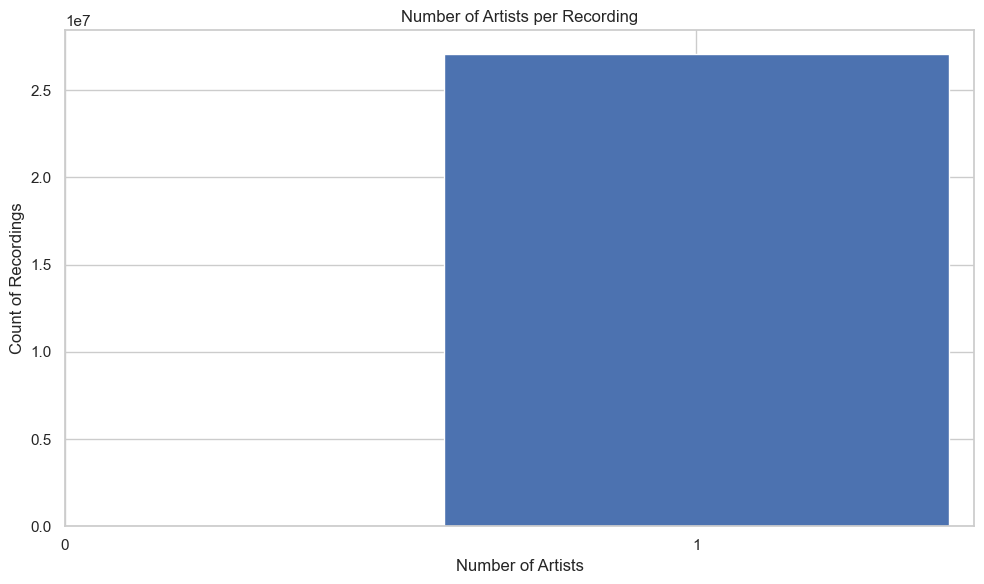


Total unique canonical MBIDs from mapping: 4620858
MBIDs found in canonical data: 4593423 (99.41%)
MBIDs not found in canonical data: 27435 (0.59%)
=== Data Flow: Finding Recordings in Canonical Data ===
Original count: 4,620,858
Processed count: 4,593,423
Retained: 99.41% (4,593,423 items)
Lost: 0.59% (27,435 items)


Found 552981 unique artists for 4593423 recordings


In [34]:
def load_canonical_data(file_path: str, max_rows: int = None) -> pl.DataFrame:
    """Load canonical MusicBrainz data, trying parquet first, then csv/zst.
    
    Args:
        file_path: Path to the canonical data file
        max_rows: Maximum number of rows to load (if None, load all)
        
    Returns:
        Polars DataFrame of the canonical data
    """
    logger.info(f"Loading canonical MusicBrainz data (max: {max_rows if max_rows else 'all'})")
    
    # Attempt to load from Parquet first
    parquet_path = os.path.join(scratch_root, "canonical_data.parquet")
    if os.path.exists(parquet_path):
        logger.info(f"Found parquet file: {parquet_path}, loading...")
        return pl.read_parquet(parquet_path, n_rows=max_rows)
    
    # Fall back to CSV if parquet is not available
    if file_path.endswith('.zst'):
        decompressed_path = os.path.join(scratch_root, os.path.basename(file_path).replace('.zst', ''))
        if not os.path.exists(decompressed_path):
            decompressed_path = decompress_zst_file(file_path, decompressed_path)
        file_path = decompressed_path
    
    return pl.read_csv(file_path, n_rows=max_rows)

# Path to the canonical data file
canonical_file_path = os.path.join(data_root, "canonical_musicbrainz_data.csv.zst")

# Check if we can access the file
if not os.path.exists(canonical_file_path):
    # Try with a sample file
    canonical_file_path = "canonical_musicbrainz_data_sample.csv"
    if not os.path.exists(canonical_file_path):
        logger.warning("Could not find canonical data file. Using mock data for exploration.")
        canonical_data = []
        for i, mbid in enumerate(list(canonical_mbids)[:100]):
            artist_mbids = ";".join([f"artist-{i:04d}-{j:04d}" for j in range(1 + i % 3)])
            canonical_data.append({
                "id": i,
                "artist_credit_id": 1000 + i,
                "artist_mbids": artist_mbids,
                "artist_credit_name": f"Artist {i}",
                "recording_mbid": mbid,
                "recording_name": f"Recording {i}",
                "release_mbid": f"release-{i:04d}",
                "release_name": f"Release {i}",
                "combined_lookup": f"lookup-{i:04d}",
                "score": 100 - (i % 20)
            })
        canonical_df = pl.DataFrame(canonical_data)
    else:
        # Load sample file
        canonical_df = pl.read_csv(canonical_file_path)
else:
    # Load the data
    canonical_df = load_canonical_data(canonical_file_path)

# Display basic statistics
calculate_metrics(canonical_df, "Canonical MusicBrainz Data")

# Analyze the structure of the data
print("\nColumns in the canonical MusicBrainz data:")
print(canonical_df.columns)

# Analyze artist data
if "artist_mbids" in canonical_df.columns:
    print("\nAnalyzing artist information...")
    # Add column with number of artists per recording
    canonical_df = canonical_df.with_columns(
        pl.col("artist_mbids").map_elements(
            lambda x: len(str(x).split(";")) if x and x.strip() else 0
        ).alias("artist_count")
    )
    # Calculate statistics about number of artists per recording
    artist_count_stats = canonical_df.select(
        pl.col("artist_count").mean().alias("Average artists per recording"),
        pl.col("artist_count").median().alias("Median artists per recording"),
        pl.col("artist_count").min().alias("Min artists per recording"),
        pl.col("artist_count").max().alias("Max artists per recording")
    )
    
    print(artist_count_stats)
    
    # Distribution of number of artists per recording
    artist_counts = canonical_df.group_by("artist_count").count().sort("artist_count")
    
    print("\nDistribution of number of artists per recording:")
    print(artist_counts)
    
    # Plot distribution
    plt.figure(figsize=(10, 6))
    plt.bar(
        artist_counts["artist_count"].to_list(),
        artist_counts["count"].to_list()
    )
    plt.title('Number of Artists per Recording')
    plt.xlabel('Number of Artists')
    plt.ylabel('Count of Recordings')
    plt.xticks(range(artist_counts["artist_count"].max() + 1))
    plt.tight_layout()
    plt.show()

# Check MBID coverage from our canonicalized mapping
if "recording_mbid" in canonical_df.columns and "canonical_mbid" in canonical_mapping.columns:
    canonical_mapping_mbids = set(canonical_mapping.get_column("canonical_mbid").to_list())
    canonical_data_mbids = set(canonical_df.get_column("recording_mbid").to_list())
    
    found_canonical_mbids = canonical_mapping_mbids.intersection(canonical_data_mbids)
    
    print(f"\nTotal unique canonical MBIDs from mapping: {len(canonical_mapping_mbids)}")
    print(f"MBIDs found in canonical data: {len(found_canonical_mbids)} ({len(found_canonical_mbids)/len(canonical_mapping_mbids)*100:.2f}%)")
    print(f"MBIDs not found in canonical data: {len(canonical_mapping_mbids) - len(found_canonical_mbids)} ({(len(canonical_mapping_mbids) - len(found_canonical_mbids))/len(canonical_mapping_mbids)*100:.2f}%)")
    
    # Track the data flow
    canonical_data_stats = track_data_flow(len(canonical_mapping_mbids), len(found_canonical_mbids), "Finding Recordings in Canonical Data")

# Get canonical data for our canonicalized MBIDs
canonical_subset = canonical_df.filter(
    pl.col("recording_mbid").is_in(canonical_mapping_mbids)
)

# Extract artist MBIDs similar to the implementation
recording_to_artists = {}
for row in canonical_subset.iter_rows(named=True):
    if "recording_mbid" in row and "artist_mbids" in row and row["artist_mbids"] and isinstance(row["artist_mbids"], str):
        recording_mbid = row["recording_mbid"]
        artist_mbids = row["artist_mbids"].split(";")
        recording_to_artists[recording_mbid] = artist_mbids

# Count unique artists
all_artists = set()
for artists in recording_to_artists.values():
    all_artists.update(artists)

print(f"\nFound {len(all_artists)} unique artists for {len(recording_to_artists)} recordings")


# 5. Exploring Artist Data


In [35]:
def load_artist_data(file_path: str, max_rows: int = 100000) -> pl.DataFrame:
    """Load MusicBrainz artist data, similar to the original implementation.
    
    Args:
        file_path: Path to the artist data file
        max_rows: Maximum number of rows to load for exploration
        
    Returns:
        Polars DataFrame of the artist data
    """
    logger.info(f"Loading MusicBrainz artist data from {file_path} (max {max_rows} rows)")
    
    # Read the file using Polars
    return pl.read_csv(file_path, n_rows=max_rows)

# Path to the artist data file
artist_file_path = os.path.join(data_root, "musicbrainz_artist.csv")

# Check if we can access the file
if not os.path.exists(artist_file_path):
    # Try with a sample file
    artist_file_path = "musicbrainz_artist_sample.csv"
    if not os.path.exists(artist_file_path):
        logger.warning(f"Could not find artist data file. Using mock data for exploration.")
        # Create mock data for demonstration
        artist_data = []
        for i, mbid in enumerate(list(all_artists)[:100]):  # Use up to 100 artist MBIDs
            artist_data.append({
                "artist_mbid": mbid,
                "name": f"Artist Name {i}"
            })
        artist_df = pl.DataFrame(artist_data)
    else:
        # Load sample file
        artist_df = pl.read_csv(artist_file_path)
else:
    # Load the actual artist data file
    artist_df = load_artist_data(artist_file_path)

# Display basic statistics
calculate_metrics(artist_df, "MusicBrainz Artist Data")

# Analyze the structure of the data
print("\nColumns in the MusicBrainz artist data:")
print(artist_df.columns)

# Analyze artist names
if "name" in artist_df.columns:
    print("\nAnalyzing artist names...")
    
    # Check for duplicate artist names
    name_dupes = artist_df.select(
        pl.col("name")
    ).is_duplicated().sum()
    
    print(f"Number of duplicate artist names: {name_dupes} ({name_dupes/artist_df.height*100:.2f}%)")
    
    if name_dupes > 0:
        print("\nSample of artists with duplicate names:")
        dupe_names = artist_df.filter(
            pl.col("name").is_duplicated()
        ).sort("name")
        
        print(dupe_names.head(10))

# Check artist coverage
if "artist_mbid" in artist_df.columns:
    artist_mbids = set(artist_df.get_column("artist_mbid").to_list())
    
    found_artists = all_artists.intersection(artist_mbids)
    
    print(f"\nTotal unique artist MBIDs from canonical data: {len(all_artists)}")
    print(f"Artists found in artist data: {len(found_artists)} ({len(found_artists)/len(all_artists)*100:.2f}%)")
    print(f"Artists not found in artist data: {len(all_artists) - len(found_artists)} ({(len(all_artists) - len(found_artists))/len(all_artists)*100:.2f}%)")
    
    # Track the data flow
    artist_stats = track_data_flow(len(all_artists), len(found_artists), "Finding Artist Names")

# Create a mapping of artist MBID to name
artist_to_name = {}
for row in artist_df.iter_rows(named=True):
    if "artist_mbid" in row and "name" in row and row["artist_mbid"] in all_artists:
        artist_to_name[row["artist_mbid"]] = row["name"]


2025-02-25 22:39:26,955 - INFO - Loading MusicBrainz artist data from /Volumes/WD Black/development/datasets/listenbrainz/data/musicbrainz_artist.csv (max 100000 rows)


=== MusicBrainz Artist Data Metrics ===
Number of rows: 100000
Number of columns: 2
Memory usage: 4.61 MB


Columns in the MusicBrainz artist data:
['artist_mbid', 'name']

Analyzing artist names...
Number of duplicate artist names: 1567 (1.57%)

Sample of artists with duplicate names:
shape: (10, 2)
┌─────────────────────────────────┬───────────┐
│ artist_mbid                     ┆ name      │
│ ---                             ┆ ---       │
│ str                             ┆ str       │
╞═════════════════════════════════╪═══════════╡
│ 0abb13f5-bb1d-4804-9285-65de7a… ┆ &         │
│ f09fb719-7020-4ee4-9b03-890de5… ┆ &         │
│ a3ce6b9a-2aa9-46c1-acae-3cd965… ┆ 100 Suns  │
│ caffc43e-ecac-496c-81f8-c99226… ┆ 100 Suns  │
│ 6b2fbd99-4edc-49f0-b502-be4301… ┆ 4 Corners │
│ c296b34a-a086-4703-90d6-804251… ┆ 4 Corners │
│ 3533c341-62ac-4250-aa40-b6055e… ┆ A.M.      │
│ 5389a29e-d6e0-47d7-a079-7f4a96… ┆ A.M.      │
│ bde9ff88-e43a-4445-b3f8-238faa… ┆ Aaron     │
│ 5970cf13-b5ac-42b9-8a2d-

# 6. End-to-End Processing Pipeline Simulation

In [36]:
print("\n\n==========================================")
print("End-to-End Processing Pipeline Simulation")
print("==========================================\n")

# Step 1: Extract user_id and recording_msid from listens
print("Step 1: Extract user_id and recording_msid from listens")
print("-------------------------------------------------------")

# We've already done this above with user_msid_df
listen_count = user_msid_df.height
print(f"Extracted {listen_count} user_id and recording_msid pairs")

# Remove nulls and duplicates
user_msid_clean = user_msid_df.filter(
    pl.col("recording_msid").is_not_null()
).unique()
clean_listen_count = user_msid_clean.height

# Track data flow
listen_stats = track_data_flow(listen_count, clean_listen_count, "Clean Listen Events")

# Step 2: Map MSIDs to MBIDs
print("\nStep 2: Map MSIDs to MBIDs")
print("-------------------------")

# Get unique MSIDs from listens
unique_msids_count = user_msid_clean.select("recording_msid").n_unique()
print(f"Found {unique_msids_count} unique MSIDs in listen data")

# We've already created filtered_mapping above
if filtered_mapping.height > 0:
    mapped_msids_count = filtered_mapping.select("recording_msid").n_unique()
    print(f"Successfully mapped {mapped_msids_count} MSIDs to MBIDs")
    
    # Track data flow
    mapping_stats = track_data_flow(unique_msids_count, mapped_msids_count, "MSID to MBID Mapping")
else:
    print("No mapping data available")
    mapped_msids_count = 0
    mapping_stats = track_data_flow(unique_msids_count, 0, "MSID to MBID Mapping")

# Step 3: Apply canonical redirects
print("\nStep 3: Apply canonical redirects")
print("-------------------------------")

# We've already created canonical_mapping above
if canonical_mapping.height > 0:
    original_mbids_count = canonical_mapping.select("recording_mbid").n_unique()
    canonical_mbids_count = canonical_mapping.select("canonical_mbid").n_unique()
    
    print(f"Found {original_mbids_count} unique MBIDs before canonicalization")
    print(f"Found {canonical_mbids_count} unique canonical MBIDs after redirects")
    
    # Check how many MBIDs were redirected
    redirected_count = canonical_mapping.filter(
        pl.col("recording_mbid") != pl.col("canonical_mbid")
    ).height
    
    print(f"{redirected_count} MBIDs were redirected ({redirected_count/canonical_mapping.height*100:.2f}%)")
    
    # Track data flow
    redirect_stats = track_data_flow(original_mbids_count, canonical_mbids_count, "Canonical Redirection")
else:
    print("No canonical mapping data available")
    redirect_stats = track_data_flow(0, 0, "Canonical Redirection")

# Step 4: Look up artists for recordings
print("\nStep 4: Look up artists for recordings")
print("------------------------------------")

# We've already created canonical_subset above
if canonical_subset.height > 0:
    canonical_mbids_count = canonical_mapping.select("canonical_mbid").n_unique()
    found_canonical_count = canonical_subset.select("recording_mbid").n_unique()
    
    print(f"Found {found_canonical_count} out of {canonical_mbids_count} canonical MBIDs in the canonical data")
    
    # We've already extracted recording_to_artists above
    print(f"Found {len(all_artists)} unique artists for {len(recording_to_artists)} recordings")
    
    # Track data flow
    artist_lookup_stats = track_data_flow(canonical_mbids_count, found_canonical_count, "Finding Artists for Recordings")
else:
    print("No canonical data available")
    artist_lookup_stats = track_data_flow(0, 0, "Finding Artists for Recordings")

# Step 5: Map artist IDs to names
print("\nStep 5: Map artist IDs to names")
print("-----------------------------")

# We've already checked artist coverage above
if len(all_artists) > 0:
    print(f"Found {len(artist_to_name)} out of {len(all_artists)} artists in the artist data")
    
    # Track data flow
    artist_name_stats = track_data_flow(len(all_artists), len(artist_to_name), "Finding Artist Names")
else:
    print("No artist data available")
    artist_name_stats = track_data_flow(0, 0, "Finding Artist Names")

# Step 6: Generate user-artist-counts
print("\nStep 6: Generate user-artist-counts")
print("---------------------------------")

# Create a mapping from MSID to artists
msid_to_artists = {}
for row in canonical_mapping.iter_rows(named=True):
    canonical_mbid = row["canonical_mbid"]
    if canonical_mbid in recording_to_artists:
        msid_to_artists[row["recording_msid"]] = recording_to_artists[canonical_mbid]

# Generate user-artist pairs
user_artist_pairs = []
for row in user_msid_clean.iter_rows(named=True):
    msid = row["recording_msid"]
    if msid in msid_to_artists:
        for artist_mbid in msid_to_artists[msid]:
            user_artist_pairs.append({
                "user_id": row["user_id"],
                "artist_id": artist_mbid
            })

# Convert to DataFrame and count listens per user-artist pair
if user_artist_pairs:
    user_artist_df = pl.DataFrame(user_artist_pairs)
    user_artist_counts = user_artist_df.group_by(["user_id", "artist_id"]).count().with_columns(
        pl.col("count").alias("listen_count")
    ).drop("count")
    
    print(f"Generated {user_artist_counts.height} user-artist-count entries from {user_msid_clean.height} listen events")
    
    # Track the final flow
    final_stats = track_data_flow(user_msid_clean.height, len(user_artist_pairs), "Generating User-Artist Counts")
else:
    print("Could not generate user-artist-count entries due to missing data")
    final_stats = track_data_flow(user_msid_clean.height, 0, "Generating User-Artist Counts")




End-to-End Processing Pipeline Simulation

Step 1: Extract user_id and recording_msid from listens
-------------------------------------------------------
Extracted 93859039 user_id and recording_msid pairs
=== Data Flow: Clean Listen Events ===
Original count: 93,859,039
Processed count: 36,261,723
Retained: 38.63% (36,261,723 items)
Lost: 61.37% (57,597,316 items)


Step 2: Map MSIDs to MBIDs
-------------------------
Found 16684273 unique MSIDs in listen data
Successfully mapped 9175609 MSIDs to MBIDs
=== Data Flow: MSID to MBID Mapping ===
Original count: 16,684,273
Processed count: 9,175,609
Retained: 55.00% (9,175,609 items)
Lost: 45.00% (7,508,664 items)


Step 3: Apply canonical redirects
-------------------------------
Found 4699610 unique MBIDs before canonicalization
Found 4620858 unique canonical MBIDs after redirects
324492 MBIDs were redirected (3.54%)
=== Data Flow: Canonical Redirection ===
Original count: 4,699,610
Processed count: 4,620,858
Retained: 98.32% (4,620,8

/var/folders/n1/mcq0j79n6y55kkrdd26_v_qr0000gn/T/ipykernel_86895/843758865.py:126: DeprecationWarning: `GroupBy.count` is deprecated. It has been renamed to `len`.
  user_artist_counts = user_artist_df.group_by(["user_id", "artist_id"]).count().with_columns(


Generated 6314304 user-artist-count entries from 36261723 listen events
=== Data Flow: Generating User-Artist Counts ===
Original count: 36,261,723
Processed count: 24,691,154
Retained: 68.09% (24,691,154 items)
Lost: 31.91% (11,570,569 items)



# 7. Overall Data Flow Visualization



Overall Data Flow Visualization



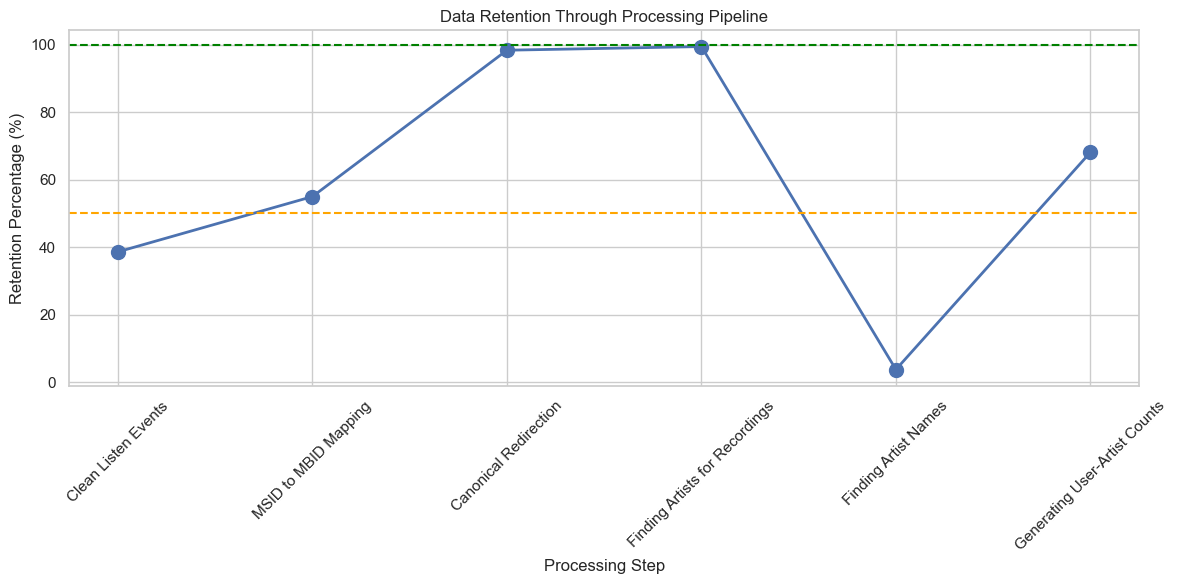

In [37]:
print("\n\n===============================")
print("Overall Data Flow Visualization")
print("===============================\n")

# Collect all flow statistics
all_stats = [
    listen_stats,
    mapping_stats,
    redirect_stats,
    artist_lookup_stats,
    artist_name_stats,
    final_stats
]

# Create a DataFrame for the flow

flow_df = pd.DataFrame(all_stats)

# Plot the data retention across steps
plt.figure(figsize=(12, 6))
plt.plot(flow_df['step'], flow_df['retention_pct'], 'o-', linewidth=2, markersize=10)
plt.axhline(y=100, color='green', linestyle='--')
plt.axhline(y=50, color='orange', linestyle='--')
plt.title('Data Retention Through Processing Pipeline')
plt.xlabel('Processing Step')
plt.ylabel('Retention Percentage (%)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


# 8. Summary and Insights

In [ ]:
print("\n\n===================")
print("Summary and Insights")
print("===================\n")

# Calculate overall data retention
starting_count = listen_stats['original_count']
ending_count = final_stats['processed_count']
overall_retention = (ending_count / starting_count) * 100 if starting_count > 0 else 0

print(f"Overall Pipeline Statistics:")
print(f"----------------------------")
print(f"Starting data points: {starting_count:,}")
print(f"Ending data points: {ending_count:,}")
print(f"Overall retention: {overall_retention:.2f}%")
print(f"Data loss: {100 - overall_retention:.2f}%")

# Key insights
print("\nKey Insights:")
print("-------------")
print("1. Main sources of data loss:")
for i, stats in enumerate(all_stats):
    if stats['loss_pct'] > 10:  # Highlight steps with more than 10% loss
        print(f"   - {stats['step']}: Lost {stats['loss_pct']:.2f}% ({stats['loss_count']:,} items)")

print("\n2. Duplicate Analysis:")
print(f"   - Duplicate listen pairs: {listen_count - user_msid_df.unique().height:,} ({(listen_count - user_msid_df.unique().height)/listen_count*100:.2f}%)")
if 'recording_msid' in mapping_df.columns:
    msid_dupes = mapping_df.select(pl.col("recording_msid")).is_duplicated().sum()
    print(f"   - Duplicate MSIDs in mapping: {msid_dupes:,} ({msid_dupes/mapping_df.height*100:.2f}%)")

print("\n3. Match Quality Analysis:")
if "match_type" in mapping_df.columns:
    for row in mapping_df.group_by("match_type").count().sort("count", descending=True).iter_rows(named=True):
        print(f"   - {row['match_type']}: {row['count']:,} ({row['count']/mapping_df.height*100:.2f}%)")

print("\n4. Artist Distribution Analysis:")
if 'artist_count' in canonical_df.columns:
    avg_artists = canonical_df.select(pl.col("artist_count").mean()).item()
    multi_artists = canonical_df.filter(pl.col("artist_count") > 1).height
    print(f"   - Average artists per recording: {avg_artists:.2f}")
    print(f"   - Recordings with multiple artists: {multi_artists:,} ({multi_artists/canonical_df.height*100:.2f}%)")
